# Burgers Optimization with a Physics-Informed NN

To illustrate how the physics-informed losses work, let's consider a 
reconstruction example with a simple yet non-linear equation in 1D:
Burgers equation $\frac{\partial u}{\partial{t}} + u \nabla u = \nu \nabla \cdot \nabla u$
for which we have a series of _observations_ at time $t=0.5$ which should be fulfilled in the solution. In addition, let's impose Dirichlet boundary conditions $u=0$
at the sides of our computational domain, and define the solution in
the time interval $t \in [0,1]$.

Note that similar to the previous forward simulation example, 
we will still be sampling the solution with 128 points ($n=128), but now we have a discretization via the NN. So we could also sample points inbetween without having to explicitly choose a basis function for interpolation. The discretization via the NN now internally determines how to use its degrees of freedom to construct the basis functions. So we have no direct control over the reconstruction.

## Preliminaries

Let's just load TF and phiflow for now, and initialize the random sampling. (_Note: this example uses an older version of phiflow (1.x), and TF 1.x._)



In [2]:
!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@1.5.1

from phi.tf.flow import *
import numpy as np

#rnd = TF_BACKEND  # for phiflow: sample different points in the domain each iteration
rnd = math.choose_backend(1)  # use same random points for all iterations

We're importing phiflow here, but we won't use it to compute a solution to the PDE. Below we'll instead use the  derivatives of an NN (as explained in the previous section) to set up a loss formulation to train an NN.

Next, we set up a simple NN with 8 fully connected layers and `tanh` activations with 20 units each. 

We'll also define the `boundary_tx` function which gives an array of constraints for the solution (all for $=0.5$ in this example), and the `open_boundary` function which contains constraints for $x= \pm1$ being 0.

In [2]:
def network(x, t):
    """ Dense neural network with 8 hidden layers and 3021 parameters in total.
        Parameters will only be allocated once (auto reuse).
    """
    y = math.stack([x, t], axis=-1)
    for i in range(8):
        y = tf.layers.dense(y, 20, activation=tf.math.tanh, name='layer%d' % i, reuse=tf.AUTO_REUSE)
    return tf.layers.dense(y, 1, activation=None, name='layer_out', reuse=tf.AUTO_REUSE)

def boundary_tx(N):
    x = np.linspace(-1,1,128)
    # precomputed solution from forward simulation:
    u = np.asarray( [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] );
    t = np.asarray(rnd.ones_like(x)) * 0.5
    perm = np.random.permutation(128) 
    return (x[perm])[0:N], (t[perm])[0:N], (u[perm])[0:N]

def _ALT_t0(N): # alternative, impose original initial state at t=0
    x = rnd.random_uniform([N], -1, 1)
    t = rnd.zeros_like(x)
    u = - math.sin(np.pi * x)
    return x, t, u

def open_boundary(N):
    t = rnd.random_uniform([N], 0, 1)
    x = math.concat([math.zeros([N//2]) + 1, math.zeros([N//2]) - 1], axis=0)
    u = math.zeros([N])
    return x, t, u


Most importantly, we can now also construct the residual loss function `f` that we'd like to minimize in order to guide the NN to retrieve a solution for our model equation. As can be seen in the equation at the top, we need derivatives w.r.t. $t$, $x$ and a second derivative for $x$. The first three lines of `f` below do just that.

Afterwards, we simply combine the derivates according to Burgers equation:

In [3]:
def f(u, x, t):
    """ Physics-based loss function with Burgers equation """
    u_t = gradients(u, t)
    u_x = gradients(u, x)
    u_xx = gradients(u_x, x)
    return u_t + u*u_x - (0.01 / np.pi) * u_xx


Next, let's set up the sampling points in the inner domain, such that we can compare the solution with the previous forward simulation in phiflow. The last `math.expand_dims()` call simply adds another `batch` dimension, so that the resulting tensor is compatible with the following examples.

A bit more interesting: grid_u will afterwards contain a full graph to evaluate our NN at $128 \times 33$ positions, and will retrieve the results in a $[1,128,33,1]$ array once we run it through `session.run`.

In [4]:
# generate array with positions: 
#   -1 to 1 spatial with 128 cells
#   0 to 1 in time with 1+32 timesteps
n=128
grids_xt = np.meshgrid(np.linspace(-1, 1, n), np.linspace(0, 1, 33), indexing='ij')
grid_x, grid_t = [tf.convert_to_tensor(t, tf.float32) for t in grids_xt]

# create 4D tensor with batch and channel dimensions in addition to space and time
# in this case gives shape=(1, n, 33, 1)
grid_u = math.expand_dims(network(grid_x, grid_t))

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Let's give this a try: we can initialize a TF session, evaluate `grid_u` and show it in an image, just like the phiflow solution we computed previously. 

(Note, as before the x axis does not show actual simulation time, but is showing 32 steps "blown" up by a factor of 16 to make the changes over time easier to see in the image.)

Size of grid_u: (1, 128, 33, 1)




Randomly initialized network state:


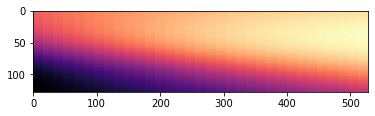

In [5]:
# test image output
import matplotlib.pyplot as plt
print("Size of grid_u: "+format(grid_u.shape))

session = Session(None)
session.initialize_variables()

def show_state(a):
    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see
    # (could also be done with more evaluations of network)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=3)
    a = np.reshape( a, [a.shape[1],a.shape[2]*a.shape[3]] )
    #print(a.shape)
    plt.imshow(a, origin='upper', cmap='magma')
    
print("Randomly initialized network state:")
show_state(session.run(grid_u))

This visualization already shows a smooth transition over space and time. So far, this is purely the random initialization of the NN that we're sampling here. So it has nothing to do with a solution of our PDE-based model up to now.

The next steps will actually evaluate the constraints in terms of data (from the `boundary` functions), and the model constraints from `f` to retrieve an actual solution to the PDE.

## The loss functions & training

As objective for the learning process we can now combine the _direct_ constraints, i.e., the solution at $t=0.5$ and the Dirchlet $u=0$ boundary conditions with the loss from the PDE residuals. For both boundary constraints we'll use 100 points below, and then sample the solution in the inner region with an additional 1000 points.

The direct constraints are evaluated via `network(x, t)[:, 0] - u`, where `x` and `t` are the "position" where we'd like to sample out solution, and `u` provides the corresponding ground truth value.

For the physical loss points, we have no ground truth solutions, but we'll only evaluate the PDE residual via the NN derivatives, to see whether the solution satisfies PDE model. If not, this directly gives us an error to be reduced via a update step in the optimization. The corresponding expression is of the form  `f(network(x, t)[:, 0], x, t)` below. Note that for both data and physics terms the `network()[:, 0]` simply discard the last size-1 dimension of the $(n,1)$ tensor returned by the network.

In [6]:
# Boundary loss
num_sample_points_bnd = 100
x_bc, t_bc, u_bc = [math.concat([v_t0, v_x], axis=0) for v_t0, v_x in zip(boundary_tx(num_sample_points_bnd), open_boundary(num_sample_points_bnd))]
x_bc, t_bc, u_bc = np.asarray(x_bc,dtype=np.float32), np.asarray(t_bc,dtype=np.float32) ,np.asarray(u_bc,dtype=np.float32)
#with app.model_scope():
loss_u = math.l2_loss(network(x_bc, t_bc)[:, 0] - u_bc)  # normalizes by first dimension, N_bc

# Physics loss inside of domain
num_sample_points_inner = 1000
x_ph, t_ph = tf.convert_to_tensor(rnd.random_uniform([num_sample_points_inner], -1, 1)), tf.convert_to_tensor(rnd.random_uniform([num_sample_points_inner], 0, 1))
loss_ph = math.l2_loss(f(network(x_ph, t_ph)[:, 0], x_ph, t_ph))  # normalizes by first dimension, N_ph

# Combine
ph_factor = 1.
loss = loss_u + ph_factor * loss_ph # allows us to control the relative influence of loss_ph 

optim = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(loss)
#optim = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss) # alternative, but not much benefit here


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The code above just initializes the evaluation of the loss, we still didn't do any optimization steps, but we're finally in a good position to get started with this.

Note: despite the simple equation, the convergence is typicaly very slow. It needs a _lot_ of iterations. To keep the runtime in a reasonable range, we only do 10k iterations by default below (`iters`). You can increase this value to get better results.

In [7]:
session.initialize_variables()

import time
start = time.time()

iters = 10000
for optim_step in range(iters+1):
  _, loss_value = session.run([optim, loss])
  if optim_step<3 or optim_step%1000==0: 
        print('Step %d, loss: %f' % (optim_step,loss_value))
        #show_state(grid_u)
        
end = time.time()
print("Runtime {:.2f}s".format(end-start))

Step 0, loss: 0.185030
Step 500, loss: 0.066632
Step 1000, loss: 0.050299
Step 1500, loss: 0.046025
Step 2000, loss: 0.042862
Step 2500, loss: 0.039872
Step 3000, loss: 0.037071
Step 3500, loss: 0.033701
Step 4000, loss: 0.026160
Step 4500, loss: 0.019593
Step 5000, loss: 0.064136
Step 5500, loss: 0.045300
Step 6000, loss: 0.040658
Step 6500, loss: 0.037709
Step 7000, loss: 0.033832
Step 7500, loss: 0.030921
Step 8000, loss: 0.027804
Step 8500, loss: 0.022738
Step 9000, loss: 0.075315
Step 9500, loss: 0.039424
Step 10000, loss: 0.033949
Runtime 83.99s


This training can take a significant amount of time, around 1 minute on a typical notebook, but at least the error goes down significantly (roughly from around 0.2 to ca. 0.03), and the network seems to successfully converge to a solution.

Let's show the reconstruction of the network, by evaluating the network at the centers of a regular grid, so that we can show the solution as an image. Note that this is actually fairly expensive, we have to run through the whole network with a few thousand weights for all of the $128 \times 32$ points in the grid.

It looks pretty good on first sight, though. There's been a very noticeable change compared to the random initialization shown above:


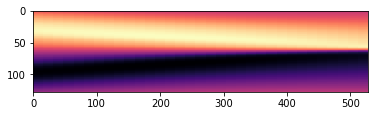

In [8]:
show_state(session.run(grid_u)) 

---

## Evaluation

Let's compare solution in a bit more detail. Here are the actual sample points used for constraining the solution (at time step 16, $t=1/2$) shown in gray, versus the reconstructed solution in blue:


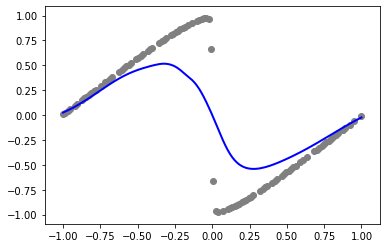

In [9]:
u = session.run(grid_u)

# solution is imposed at t=1/2 , which is 16 in the array
bc_tx = 16 
uT = u[0,:,bc_tx,0]

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(uT)), uT, lw=2, color='blue')
fig.scatter(x_bc[0:100], u_bc[0:100], color='gray')


Not too bad at the sides of the domain (the Dirichlet boundary conditions $u=0$ are fulfilled), but the shock in the center (at $x=0$) is not well represented.

Let's check how well the initial state at $t=0$ was reconstructed. That's the most interesting, and toughest part of the problem (the rest basically follows from the model equation and boundary conditions, given the first state).

It turns out, the accuracy of the initial state is actually not that great: the blue curve from the PINN is quite far away from the constraits (shown in gray)... The solution will get better with larger number of iterations, but it requires a surprisingly large number of them for a fairly simple case. 


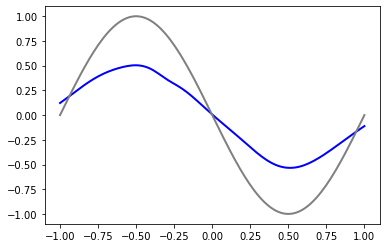

In [10]:
# ground truth solution at t0
t0gt = np.asarray( [ [-math.sin(np.pi * x) * 1.] for x in np.linspace(-1,1,n)] )

velP0 = u[0,:,0,0]

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(velP0)), velP0, lw=2, color='blue')
fig.plot(np.linspace(-1,1,len(t0gt)), t0gt, lw=2, color='gray') # optionally show GT, compare to blue


Especially the maximum / minimum at $x=\pm 1/2$ are far off, and the boudaries at $x=\pm 1$ are not fulfilled: the solution is not at zero.

We have the forward simulator for this simulation, so we can use the $t=0$ solution of the network to 
evaluate how well the temporal evoluation was reconstructed by the PINN. This measures how well the temporal evolution of the model equation was captured via the soft constraints of the PINN loss.

The graph below shows the initial state in blue, and two evolved states at $t=8/32$ and $t=15/32$. Note that this is all from the simulated version, we'll show the PINN version next. 

(Note: The code segments below also have some optional code to show the states at `[steps//4]`. It's commented out by default, you can uncomment or add additional ones to visualize more of the time evolution if you like.)

(1, 128, 1)


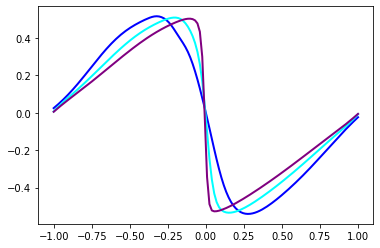

In [19]:
# re-simulate with phiflow from solution at t=0
dt = 1./32.
steps = 32-bc_tx # depends on where BCs were imposed
initial = u[...,bc_tx:(bc_tx+1),0] # np.reshape(u0, [1,len(u0),1]) 
print(initial.shape)

domain = Domain([n], boundaries=PERIODIC, box=box[-1:1])
state = [BurgersVelocity(domain, velocity=initial, viscosity=0.01/np.pi)]
physics = Burgers()

for i in range(steps):
    state.append( physics.step(state[-1],dt=dt) )

# we only need "velocity.data" from each phiflow state
vel_resim = [x.velocity.data for x in state]

fig = plt.figure().gca()
pltx = np.linspace(-1,1,len(vel_resim[0].flatten()))
fig.plot(pltx, vel_resim[ 0].flatten(), lw=2, color='blue')
#fig.plot(pltx, vel_resim[steps//4].flatten(), lw=2, color='green')
fig.plot(pltx, vel_resim[steps//2].flatten(), lw=2, color='cyan')
fig.plot(pltx, vel_resim[steps-1].flatten(), lw=2, color='purple')
#fig.plot(pltx, t0gt, lw=2, color='gray') # optionally show GT, compare to blue


And here is the PINN output from `u` at the same time steps:


(128,)


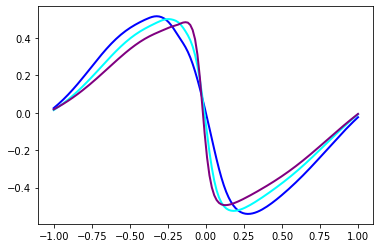

In [18]:
velP = [u[0,:,x,0] for x in range(33)]
print(velP[0].shape)

fig = plt.figure().gca()
fig.plot(pltx, velP[bc_tx+ 0].flatten(), lw=2, color='blue')
#fig.plot(pltx, velP[bc_tx+steps//4].flatten(), lw=2, color='green')
fig.plot(pltx, velP[bc_tx+steps//2].flatten(), lw=2, color='cyan')
fig.plot(pltx, velP[bc_tx+steps-1].flatten(), lw=2, color='purple')


Not surprisingly, the errors grow over time. Especially the steepening of the solution near the shock at $x=0$ is not "captured" well. It's a bit difficult to see in these two graphs, though, let's quantify the error and show the actual difference:

Mean absolute error for re-simulation across 16 steps: 0.01142


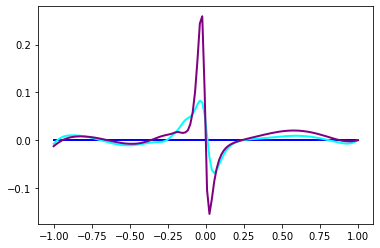

In [13]:
error = np.sum( np.abs( np.asarray(vel_resim[0:16]).flatten() - np.asarray(velP[bc_tx:bc_tx+steps]).flatten() )) / (steps*n)
print("Mean absolute error for re-simulation across {} steps: {:7.5f}".format(steps,error))

fig = plt.figure().gca()
fig.plot(pltx, (vel_resim[0       ].flatten()-velP[bc_tx         ].flatten()), lw=2, color='blue')
#fig.plot(pltx, (vel_resim[steps//4].flatten()-velP[bc_tx+steps//4].flatten()), lw=2, color='green')
fig.plot(pltx, (vel_resim[steps//2].flatten()-velP[bc_tx+steps//2].flatten()), lw=2, color='cyan')
fig.plot(pltx, (vel_resim[steps-1 ].flatten()-velP[bc_tx+steps-1 ].flatten()), lw=2, color='purple')


This should show a mean absolute error of ca. $1.5 \cdot 10^{-2}$ between ground truth re-simulation and the PINN evolution, which is significant for the value range of the simulation.

And for comparison with the forward simulation and following cases, here are also all steps over time with a color map.

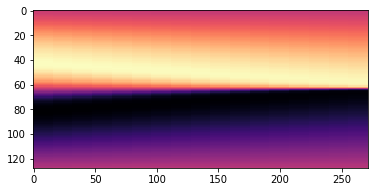

In [14]:
# show re-simulated solution again as full image over time
sn = np.concatenate(vel_resim, axis=-1)
sn = np.reshape(sn, list(sn.shape)+[1] ) # print(sn.shape)
show_state(sn)

Next, we'll store the full solution over the course of the $t=0 \dots 1$ time interval, so that we can compare it later on to the full solution from a regular forward solve and compare it to the differential physics solution.

Thus, stay tuned for the full evaluation and the comparison. It will follow in the file `diffphys-code-tf.ipynb`, after we've discussed the details of how to run the differential physics optimization.

In [20]:
vels = session.run(grid_u) # special for showing NN results, run through TF 
vels = np.reshape( vels, [vels.shape[1],vels.shape[2]] )

# save for comparison with other methods
import os; os.makedirs("./temp",exist_ok=True)
np.savez_compressed("./temp/burgers-pinn-solution.npz",vels) ; print("Vels array shape: "+format(vels.shape))

Vels array shape: (128, 33)


---

## Next steps

This setup is just a starting point for PINNs and physical soft-constraints, of course. The parameters of the setup were chosen to compare to run relatively quickly. As we'll show in the next sections, the behavior of such an inverse solve can be improved substantially by a tighter integration of solver and learning. 

The solution of the PINN setup above can also directly be improved, however. E.g., try to:

* Adjust parameters of the training to further decrease the error without making the solution diverge
* Adapt the NN architecture for further improvements (keep track of the weight count, though!)
* Activate a different optimizer, and observe the changing behavior (this typically requires adjusting the learning rate). Note that the more complex optimizers don't necessarily do better in this relatively simple example.
* Or modify the setup to make the test case more interesting: e.g., move the boundary conditions further back in time, to let the reconstruction go "further backward" in time.